# Regressor de fluxo

A principal ideia deste regressor é:

* Encontrar os fluxos baseados nas features como populacao, distancia da ligacao, REGIC.

* Verificar quais features possuem mais influência no regressor

* Testar diferentes modelos

In [1]:
import pandas as pd

In [77]:
df_cidades

,cod_cidade,nome_cidade,populacao_2021,area,latitude,longitude,cod_uf,nome_uf,uf,pais,densidade_2021
0,1100106,Arranjo Populacional Internacional de Guajará-...,46930.0,24856.877,-10.78890,-65.3296,11,Rondônia,RO,BRA,1.888009
1,1100205,Arranjo Populacional de Porto Velho/RO,577020.0,40934.820,-8.76077,-63.8999,11,Rondônia,RO,BRA,14.096068
2,1200054,Arranjo Populacional Internacional de Assis Br...,7649.0,4979.073,-10.92980,-69.5738,12,Acre,AC,BRA,1.536230
3,1200104,Arranjo Populacional Internacional de Cobija/B...,46102.0,5580.848,-10.99500,-68.7497,12,Acre,AC,BRA,8.260752
4,1303007,Arranjo Populacional de Nhamundá/AM,28659.0,25878.709,-2.20793,-56.7112,13,Amazonas,AM,BRA,1.107435
...,...,...,...,...,...,...,...,...,...,...,...
4894,1508407,Xinguara,45416.0,3779.348,-7.09830,-49.9437,15,Pará,PA,BRA,12.016888
4895,2933604,Xique-Xique,46562.0,5079.662,-10.82300,-42.7245,29,Bahia,BA,BRA,9.166358
4896,2517407,Zabelê,2269.0,106.811,-8.07901,-37.1057,25,Paraíba,PB,BRA,21.243130
4897,3557154,Zacarias,2784.0,319.056,-21.05060,-50.0552,35,São Paulo,SP,BRA,8.725741


In [76]:
#Dados arranjos/mun
df_cidades = pd.read_csv("../data/integrado/arr_mun.csv")

#Dataframe com os rotulos
df_rodoviario = pd.read_csv("../data/calculado/arr_calculo_qtd_fluxo.csv")

#Dataframe com as features
#Dados das ligacoes rodoviarias e hidroviaria IBGE 2016
df_li_trans = pd.read_csv('../data/fluxo_transporte/lig_rodo_hidro.csv', sep=",")
df_li_trans = pd.DataFrame(df_li_trans[['CODMUNDV_A', 'CODMUNDV_B','VAR03','VAR04','VAR06']])
df_li_trans.rename(columns={"ID": "id", "CODMUNDV_A": "cod_mun_a", "CODMUNDV_B": "cod_mun_b",'VAR03':"custo_min",'VAR04':"tempo_min", "VAR06": "freq_saida"}, inplace=True)

#Dados do REGIC 2018
#Integrado
df_regic = pd.read_csv('../data/integrado/cidades_regic.csv')
#Bruto
df_regic_lig = pd.read_excel(open('../data/regic/REGIC2018_Ligacoes_entre_Cidades.xlsx', 'rb'), sheet_name='REGIC2018_Ligacoes_entre_Cidade', 
                               dtype = {'cod_ori': int, 'cod_dest': int})
df_regic_lig.rename(columns={"cod_ori":"cod_origem", "cod_dest":"cod_destino"}, inplace=True)                            

In [27]:
df_li_trans_2 = df_li_trans.copy()
df_li_trans_2.rename(columns={"cod_mun_a":"cod_mun_b", "cod_mun_b":"cod_mun_a"}, inplace=True)

df_lig = pd.concat([df_li_trans_2,df_li_trans])
df_lig.rename(columns={"cod_mun_a":"cod_origem", "cod_mun_b":"cod_destino"}, inplace=True)

In [28]:
df_regic = df_regic.merge(df_cidades[['cod_cidade','populacao_2021']], 
                how='inner', 
                left_on=["cod_mun"], 
                right_on=["cod_cidade"])

In [29]:
df_regic_dest = pd.DataFrame(df_regic.add_suffix('_dest'))
df_regic_ori = pd.DataFrame(df_regic.add_suffix('_ori'))

df_regic_merge = df_lig.merge(df_regic_dest, 
                how='inner', 
                left_on=["cod_destino"], 
                right_on=["cod_mun_dest"])

df_regic_merge = df_regic_merge.merge(df_regic_ori, 
                how='inner', 
                left_on=["cod_origem"], 
                right_on=["cod_mun_ori"])


In [207]:
df_features_temp =  df_rodoviario.merge(df_regic_merge, 
                how='inner', 
                left_on=["cod_destino", "cod_origem"], 
                right_on=["cod_destino", "cod_origem"])

In [128]:
df_features_temp

,cod_origem,cod_destino,passageiros_rodov,passageiros_aereo,passageiros_total,prob_rodov,prob_aereo,prob_total,custo_min,tempo_min,...,ia_saude_a_ori,ia_ensino_sup_ori,ia_cultura_ori,ia_esporte_ori,ia_aeroporto_ori,ia_jornal_ori,ia_transporte_ori,num_leitos_ori,cod_cidade_ori,populacao_2021_ori
0,1100205,3131307,195.0,0.0,195.0,0.007397,0.000000,0.000495,512.00,2640,...,703520.266667,305411.296667,242445.350000,418772.066667,855048.316667,656108.950000,218109.491135,3.295974,1100205,577020.0
1,1100205,3136207,166.0,0.0,166.0,0.006297,0.000000,0.000421,670.16,3192,...,703520.266667,305411.296667,242445.350000,418772.066667,855048.316667,656108.950000,218109.491135,3.295974,1100205,577020.0
2,1100205,3205309,3.0,0.0,3.0,0.000114,0.000000,0.000008,680.91,3000,...,703520.266667,305411.296667,242445.350000,418772.066667,855048.316667,656108.950000,218109.491135,3.295974,1100205,577020.0
3,1100205,3509502,318.0,13856.0,14174.0,0.012063,0.037677,0.035963,428.04,2400,...,703520.266667,305411.296667,242445.350000,418772.066667,855048.316667,656108.950000,218109.491135,3.295974,1100205,577020.0
4,1100205,3541406,3.0,0.0,3.0,0.000114,0.000000,0.000008,447.01,2690,...,703520.266667,305411.296667,242445.350000,418772.066667,855048.316667,656108.950000,218109.491135,3.295974,1100205,577020.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22783,5221601,4219507,1.0,0.0,1.0,0.000923,0.000000,0.000923,369.22,2040,...,1173.300000,46476.399708,51864.909886,46568.613333,0.000000,77536.042964,49625.822786,2.163264,5221601,41150.0
22784,5221601,4219705,1.0,0.0,1.0,0.000923,0.000000,0.000923,374.52,2070,...,1173.300000,46476.399708,51864.909886,46568.613333,0.000000,77536.042964,49625.822786,2.163264,5221601,41150.0
22785,5221601,5201108,15.0,0.0,15.0,0.013838,0.000000,0.013838,46.01,210,...,1173.300000,46476.399708,51864.909886,46568.613333,0.000000,77536.042964,49625.822786,2.163264,5221601,41150.0
22786,5221601,5208103,1.0,0.0,1.0,0.000923,0.000000,0.000923,21.55,120,...,1173.300000,46476.399708,51864.909886,46568.613333,0.000000,77536.042964,49625.822786,2.163264,5221601,41150.0


In [208]:
#calulando distancia entre ligacoes
df_cidades_dest = pd.DataFrame(df_cidades.add_suffix('_dest'))
df_cidades_ori = pd.DataFrame(df_cidades.add_suffix('_ori'))

df_features_temp =  df_features_temp.merge(df_cidades_ori[["cod_cidade_ori", "latitude_ori", "longitude_ori", "uf_ori"]], 
                how='inner', 
                left_on=["cod_origem"], 
                right_on=["cod_cidade_ori"])

df_features_temp =  df_features_temp.merge(df_cidades_dest[["cod_cidade_dest", "latitude_dest", "longitude_dest", "uf_dest"]], 
                how='inner', 
                left_on=["cod_destino"], 
                right_on=["cod_cidade_dest"])


In [209]:
from geopy import distance

df_features_temp["distancia"] = df_features_temp.apply(lambda row: distance.distance((row["latitude_ori"], row["longitude_ori"]), (row["latitude_dest"], row["longitude_dest"])).km, axis=1)

In [210]:
### Drop viagens dentro do mesmo estado
df_features_temp = df_features_temp[df_features_temp["uf_ori"] != df_features_temp["uf_dest"]]

In [211]:
df_label = df_features_temp[["passageiros_rodov"]]

df_features = df_features_temp[[
        'custo_min', 'tempo_min',
        'pib_dest', 'PIB_agro_dest', 'PIB_ind_dest',
        'PIB_serv_dest', 'PIB_pub_dest', 'hierarquia_dest',
        'CGT_dest', 'CI_dest', 'CGP_dest',
        'indice_atracao_dest', 'ia_vestuario_dest', 'ia_moveis_dest',
        'ia_saude_bm_dest', 'ia_saude_a_dest', 'ia_ensino_sup_dest',
        'ia_cultura_dest', 'ia_esporte_dest', 'ia_aeroporto_dest',
        'ia_jornal_dest', 'ia_transporte_dest', 'num_leitos_dest',
        'pib_ori', 'PIB_agro_ori', 'PIB_ind_ori', 'PIB_serv_ori',
        'PIB_pub_ori', 'hierarquia_ori', 'CGT_ori',
        'CI_ori', 'CGP_ori', 'indice_atracao_ori', 'ia_vestuario_ori',
        'ia_moveis_ori', 'ia_saude_bm_ori', 'ia_saude_a_ori',
        'ia_ensino_sup_ori', 'ia_cultura_ori', 'ia_esporte_ori',
        'ia_aeroporto_ori', 'ia_jornal_ori', 'ia_transporte_ori','num_leitos_ori',
        'populacao_2021_dest', 'populacao_2021_ori', 'distancia'
       ]]

In [170]:
df_label_2 = df_features_temp[["passageiros_rodov"]]

df_features_2 = df_features_temp[[
        'custo_min', 'tempo_min',
        'populacao_2021_dest', 'populacao_2021_ori', 'distancia'
       ]]

In [171]:
df_features_2

,custo_min,tempo_min,freq_saida,populacao_2021_dest,populacao_2021_ori,distancia
0,512.00,2640,7.5,569830.0,577020.0,2588.017100
1,350.67,1920,14.0,569830.0,4104434.0,1510.916286
2,323.35,1313,16.0,569830.0,1235261.0,1309.268558
3,271.79,1350,11.0,569830.0,1088032.0,1115.052371
4,221.84,1200,9.0,569830.0,3877453.0,839.091337
...,...,...,...,...,...,...
22774,68.91,540,7.0,5514.0,45866.0,468.738587
22775,68.01,480,7.0,5332.0,45866.0,406.987059
22778,132.50,540,49.0,38095.0,436591.0,541.573213
22779,104.20,450,28.0,38095.0,22635.0,443.976595


In [516]:
df_features_label = df_features_temp[[
        'custo_min', 'tempo_min', 'freq_saida',
        'pib_dest', 'PIB_agro_dest', 'PIB_ind_dest',
        'PIB_serv_dest', 'PIB_pub_dest', 'hierarquia_dest',
        'CGT_dest', 'CI_dest', 'CGP_dest',
        'indice_atracao_dest', 'ia_vestuario_dest', 'ia_moveis_dest',
        'ia_saude_bm_dest', 'ia_saude_a_dest', 'ia_ensino_sup_dest',
        'ia_cultura_dest', 'ia_esporte_dest', 'ia_aeroporto_dest',
        'ia_jornal_dest', 'ia_transporte_dest', 'num_leitos_dest',
        'pib_ori', 'PIB_agro_ori', 'PIB_ind_ori', 'PIB_serv_ori',
        'PIB_pub_ori', 'hierarquia_ori', 'CGT_ori',
        'CI_ori', 'CGP_ori', 'indice_atracao_ori', 'ia_vestuario_ori',
        'ia_moveis_ori', 'ia_saude_bm_ori', 'ia_saude_a_ori',
        'ia_ensino_sup_ori', 'ia_cultura_ori', 'ia_esporte_ori',
        'ia_aeroporto_ori', 'ia_jornal_ori', 'ia_transporte_ori','num_leitos_ori',
        'populacao_2021_dest', 'populacao_2021_ori', "passageiros_rodov"
       ]]

In [213]:
#Transformando variáveis categóricas em numéricas
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

hier = df_features["hierarquia_ori"].unique()
hier.sort()
le.fit(hier)
df_features["hierarquia_ori"] = le.transform(df_features["hierarquia_ori"])
df_features["hierarquia_dest"] = le.transform(df_features["hierarquia_dest"])


/var/folders/rv/x_8qm7392xv0jjj7dh82d9nm0000gn/T/ipykernel_788/372019195.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features["hierarquia_ori"] = le.transform(df_features["hierarquia_ori"])
/var/folders/rv/x_8qm7392xv0jjj7dh82d9nm0000gn/T/ipykernel_788/372019195.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features["hierarquia_dest"] = le.transform(df_features["hierarquia_dest"])


In [214]:
#Preenchendo dados faltantes
df_features = df_features.fillna(0)

In [215]:
df_features.shape

(19586, 47)

In [216]:
#Aplicando log para a varável target
from numpy import log10
import numpy as np
df_label["passageiros_rodov_log"] = log10(df_label["passageiros_rodov"])
df_label["passageiros_rodov_log"].replace([np. inf, -np. inf], 0, inplace=True)


/opt/miniconda3/envs/alerta_epidemia/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rv/x_8qm7392xv0jjj7dh82d9nm0000gn/T/ipykernel_788/4142859930.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_label["passageiros_rodov_log"] = log10(df_label["passageiros_rodov"])
/var/folders/rv/x_8qm7392xv0jjj7dh82d9nm0000gn/T/ipykernel_788/4142859930.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_label["passageiros_rodov_log"].replace([n

In [217]:
#Tranformando dataset to array
X = df_features.to_numpy()
y = df_label["passageiros_rodov"].values.ravel()
y_log = df_label["passageiros_rodov_log"].values.ravel()

In [218]:
#Perform Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X)
X_sc = sc.transform(X)

Visualizando os dados

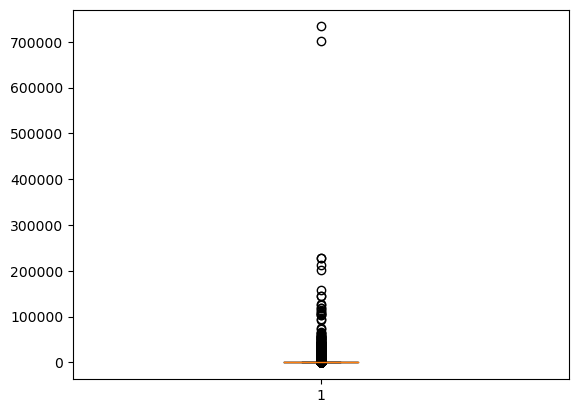

In [219]:
import matplotlib.pyplot as plt
plt.boxplot(y)
plt.show()

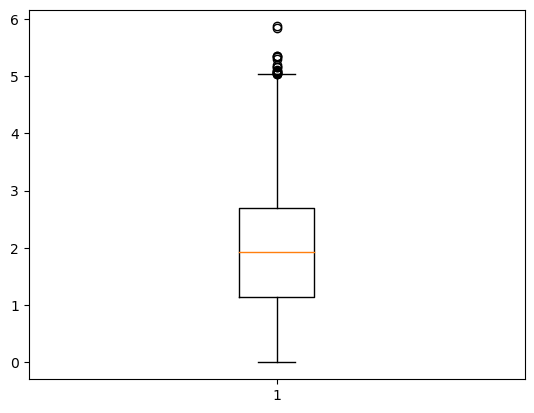

In [163]:
plt.boxplot(y_log)
plt.show()

In [517]:
df_features_label["hierarquia_ori"] = le.transform(df_features_label["hierarquia_ori"])
df_features_label["hierarquia_dest"] = le.transform(df_features_label["hierarquia_dest"])
df_features_label = df_features_label.fillna(0)

/var/folders/rv/x_8qm7392xv0jjj7dh82d9nm0000gn/T/ipykernel_58357/1203310472.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features_label["hierarquia_ori"] = le.transform(df_features_label["hierarquia_ori"])
/var/folders/rv/x_8qm7392xv0jjj7dh82d9nm0000gn/T/ipykernel_58357/1203310472.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features_label["hierarquia_dest"] = le.transform(df_features_label["hierarquia_dest"])


### Dados Balanceados

In [195]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_features, df_label,random_state=10, test_size=0.25)

In [200]:
df_features_label = pd.concat([X_train, y_train[['passageiros_rodov']]], axis=1)

In [202]:
df_features_label

,custo_min,tempo_min,pib_dest,PIB_agro_dest,PIB_ind_dest,PIB_serv_dest,PIB_pub_dest,hierarquia_dest,CGT_dest,CI_dest,...,ia_cultura_ori,ia_esporte_ori,ia_aeroporto_ori,ia_jornal_ori,ia_transporte_ori,num_leitos_ori,populacao_2021_dest,populacao_2021_ori,distancia,passageiros_rodov
18251,41.35,435,1354474,75248,313210,667955,169451,6,3.402777,2.499687,...,44409.266667,14968.440000,0.000000e+00,7147.566667,96939.595609,3.778216,41246.0,31067.0,253.497682,34.0
22627,32.91,170,96567,9662,24504,24467,32314,10,0.000000,1.146128,...,104338.619765,89246.565861,0.000000e+00,14387.456667,105662.280945,2.217174,8725.0,134629.0,111.220474,411.0
18314,111.41,795,2645230,141719,255125,1571416,289809,6,3.570543,2.667453,...,96440.300000,148280.157332,0.000000e+00,87318.500000,68745.273809,2.377616,62413.0,96102.0,472.631759,85.0
14178,81.19,520,1533996,39799,225017,807320,261871,7,3.296665,2.342423,...,133777.166833,89962.308318,0.000000e+00,0.000000,187790.637759,2.891253,64674.0,200372.0,279.124164,148.0
13898,224.97,1195,18177353,50074,4349430,9389773,1840216,5,4.149342,3.246252,...,24015.815135,2295.930000,0.000000e+00,12175.056096,4604.101940,4.387591,501364.0,16144.0,759.217290,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10867,305.12,1140,5308880,158426,1830733,2114454,478795,7,3.738622,2.960471,...,30963.696667,8919.765845,0.000000e+00,0.000000,82009.783569,1.907530,113293.0,10838.0,1061.344470,7.0
8306,400.99,2074,13107354,61212,2332292,7070541,1659882,4,4.414539,3.300595,...,318840.245720,210383.931293,0.000000e+00,46214.553168,206519.763314,1.809747,624107.0,472545.0,1479.495986,93.0
20434,199.09,975,1601485,176650,260759,666723,328577,7,3.236033,2.390935,...,17495.700000,15384.680000,0.000000e+00,11832.333333,18024.104295,2.632546,101541.0,17017.0,664.310799,27.0
8308,313.10,1680,13107354,61212,2332292,7070541,1659882,4,4.414539,3.300595,...,928554.305051,859695.178338,1.885002e+06,518980.280076,350894.819190,3.606510,624107.0,632816.0,1457.972529,1156.0


In [ ]:
# # Balanceando os dados
# import smogn


# rodoviario_smogn = smogn.smoter(

#     data = df_features_label, 
#     y = "passageiros_rodov"
# )

# rodoviario_smogn.to_csv('rodoviario_smogn_train.csv', index=False) 

In [24]:
df_features_bal.tail()

,custo_min,tempo_min,freq_saida,pib_dest,PIB_agro_dest,PIB_ind_dest,PIB_serv_dest,PIB_pub_dest,hierarquia_dest,CGT_dest,...,ia_ensino_sup_ori,ia_cultura_ori,ia_esporte_ori,ia_aeroporto_ori,ia_jornal_ori,ia_transporte_ori,num_leitos_ori,populacao_2021_dest,populacao_2021_ori,passageiros_rodov
17864,82.02,480,21.0,565667,36876,29415,299932,139200,8,2.623249,...,46476.399708,51864.909886,46568.613333,0.0,77536.042964,49625.822786,2.163264,26403.0,41150.0,21.0
17865,40.00,215,135.0,2034195,28257,215117,1011961,528421,6,3.527372,...,46476.399708,51864.909886,46568.613333,0.0,77536.042964,49625.822786,2.163264,88428.0,41150.0,47.0
17866,55.70,300,28.0,1501243,86052,276489,631965,301998,7,2.887054,...,46476.399708,51864.909886,46568.613333,0.0,77536.042964,49625.822786,2.163264,53618.0,41150.0,1.0
17867,143.94,600,7.0,32536256,556693,6267618,15005187,2682010,4,4.699742,...,46476.399708,51864.909886,46568.613333,0.0,77536.042964,49625.822786,2.163264,706597.0,41150.0,37.0
17868,21.55,120,66.0,60627,18866,2686,16979,19057,10,1.431364,...,46476.399708,51864.909886,46568.613333,0.0,77536.042964,49625.822786,2.163264,4098.0,41150.0,1.0


In [47]:
df_features_bal_temp = pd.read_csv('rodoviario_smogn.csv')
df_features_bal = df_features_bal_temp.drop(columns=["passageiros_rodov"])
df_label_bal = df_features_bal_temp[["passageiros_rodov"]]

In [37]:
#Corrigindo questão de conjunto de teste tbm estar balanceado
correcao = df_features_temp.merge(df_features_bal_temp, 
                how='inner', 
                left_on=[
        'custo_min', 'tempo_min', 'freq_saida',
        'pib_dest', 'PIB_agro_dest', 'PIB_ind_dest',
        'PIB_serv_dest', 'PIB_pub_dest',
        'CGT_dest', 'CI_dest', 'CGP_dest',
        'indice_atracao_dest', 'ia_vestuario_dest', 'ia_moveis_dest',
        'ia_saude_bm_dest', 'ia_saude_a_dest', 'ia_ensino_sup_dest',
        'ia_cultura_dest', 'ia_esporte_dest', 'ia_aeroporto_dest',
        'ia_jornal_dest', 'ia_transporte_dest', 'num_leitos_dest',
        'pib_ori', 'PIB_agro_ori', 'PIB_ind_ori', 'PIB_serv_ori',
        'PIB_pub_ori', 'CGT_ori',
        'CI_ori', 'CGP_ori', 'indice_atracao_ori', 'ia_vestuario_ori',
        'ia_moveis_ori', 'ia_saude_bm_ori', 'ia_saude_a_ori',
        'ia_ensino_sup_ori', 'ia_cultura_ori', 'ia_esporte_ori',
        'ia_aeroporto_ori', 'ia_jornal_ori', 'ia_transporte_ori','num_leitos_ori',
        'populacao_2021_dest', 'populacao_2021_ori', "passageiros_rodov"
       ], 
        right_on=[
        'custo_min', 'tempo_min', 'freq_saida',
        'pib_dest', 'PIB_agro_dest', 'PIB_ind_dest',
        'PIB_serv_dest', 'PIB_pub_dest',
        'CGT_dest', 'CI_dest', 'CGP_dest',
        'indice_atracao_dest', 'ia_vestuario_dest', 'ia_moveis_dest',
        'ia_saude_bm_dest', 'ia_saude_a_dest', 'ia_ensino_sup_dest',
        'ia_cultura_dest', 'ia_esporte_dest', 'ia_aeroporto_dest',
        'ia_jornal_dest', 'ia_transporte_dest', 'num_leitos_dest',
        'pib_ori', 'PIB_agro_ori', 'PIB_ind_ori', 'PIB_serv_ori',
        'PIB_pub_ori', 'CGT_ori',
        'CI_ori', 'CGP_ori', 'indice_atracao_ori', 'ia_vestuario_ori',
        'ia_moveis_ori', 'ia_saude_bm_ori', 'ia_saude_a_ori',
        'ia_ensino_sup_ori', 'ia_cultura_ori', 'ia_esporte_ori',
        'ia_aeroporto_ori', 'ia_jornal_ori', 'ia_transporte_ori','num_leitos_ori',
        'populacao_2021_dest', 'populacao_2021_ori', "passageiros_rodov"
       ]) 

In [42]:
corr2 = df_features_temp.merge(correcao[["cod_destino", "cod_origem"]],indicator = True, how='left',
                        left_on=["cod_destino", "cod_origem"], 
                        right_on=["cod_destino", "cod_origem"]).loc[lambda x : x['_merge']!='both'] 

In [72]:
test = corr2[[
        'custo_min', 'tempo_min', 'freq_saida',
        'pib_dest', 'PIB_agro_dest', 'PIB_ind_dest',
        'PIB_serv_dest', 'PIB_pub_dest', 'hierarquia_dest',
        'CGT_dest', 'CI_dest', 'CGP_dest',
        'indice_atracao_dest', 'ia_vestuario_dest', 'ia_moveis_dest',
        'ia_saude_bm_dest', 'ia_saude_a_dest', 'ia_ensino_sup_dest',
        'ia_cultura_dest', 'ia_esporte_dest', 'ia_aeroporto_dest',
        'ia_jornal_dest', 'ia_transporte_dest', 'num_leitos_dest',
        'pib_ori', 'PIB_agro_ori', 'PIB_ind_ori', 'PIB_serv_ori',
        'PIB_pub_ori', 'hierarquia_ori', 'CGT_ori',
        'CI_ori', 'CGP_ori', 'indice_atracao_ori', 'ia_vestuario_ori',
        'ia_moveis_ori', 'ia_saude_bm_ori', 'ia_saude_a_ori',
        'ia_ensino_sup_ori', 'ia_cultura_ori', 'ia_esporte_ori',
        'ia_aeroporto_ori', 'ia_jornal_ori', 'ia_transporte_ori','num_leitos_ori',
        'populacao_2021_dest', 'populacao_2021_ori'
       ]]
test = test.fillna(0)

In [48]:
from numpy import log10
import numpy as np
df_label_bal["passageiros_rodov_log"] = log10(df_label_bal["passageiros_rodov"])
df_label_bal["passageiros_rodov_log"].replace([np. inf, -np. inf], 0, inplace=True)

#Tranformando dataset to array
X = df_features_bal.to_numpy()
y = df_label_bal["passageiros_rodov"].values.ravel()
y_log = df_label_bal["passageiros_rodov_log"].values.ravel()

#Executando Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X)
X_sc = sc.transform(X)

/opt/miniconda3/envs/alerta_epidemia/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/rv/x_8qm7392xv0jjj7dh82d9nm0000gn/T/ipykernel_788/14128395.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_label_bal["passageiros_rodov_log"] = log10(df_label_bal["passageiros_rodov"])
/var/folders/rv/x_8qm7392xv0jjj7dh82d9nm0000gn/T/ipykernel_788/14128395.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_label_bal["passageiros_rodov_log"].re

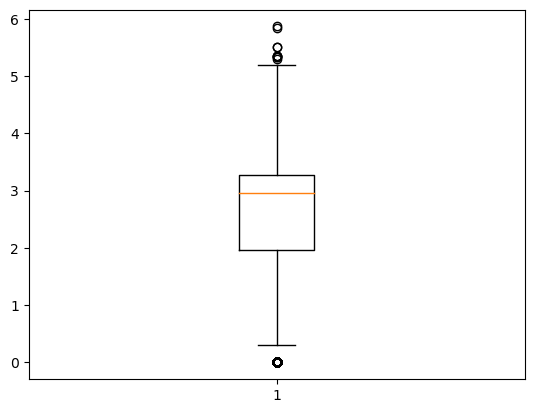

In [49]:
import matplotlib.pyplot as plt
plt.boxplot(y_log)
plt.show()

## Classificadores


In [220]:
from time import time

from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

In [221]:
#Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_sc, y,random_state=10, test_size=0.3)
# X_train, X_test, y_train, y_test = train_test_split(X_sc, y_log,random_state=10, test_size=0.25)

# test["hierarquia_ori"] = le.transform(test["hierarquia_ori"])
# test["hierarquia_dest"] = le.transform(test["hierarquia_dest"])

# X_train = X_sc
# X_test = sc.transform(test.to_numpy())
# y_train = y
# y_test = corr2["passageiros_rodov"].values.ravel()
# # y_test = label_temp.values.ravel()

In [222]:
regressors = [
    KNeighborsRegressor(),
    GradientBoostingRegressor(),
    ExtraTreesRegressor(),
    RandomForestRegressor(),
    DecisionTreeRegressor(),
    LinearRegression(),
    Lasso(),
    Ridge(),
    SVR()
]

In [223]:
head = 10
for model in regressors:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(y_test, y_pred))
    print("\tMean absolute error:", mean_absolute_error(y_test, y_pred))
    print("\tR2 score:", r2_score(y_test, y_pred))
    print()

KNeighborsRegressor()
	Training time: 0.002s
	Prediction time: 0.849s
	Explained variance: 0.23870694535228476
	Mean absolute error: 1013.7148740639892
	R2 score: 0.23788445912045098

GradientBoostingRegressor()
	Training time: 10.643s
	Prediction time: 0.011s
	Explained variance: 0.6177505685709643
	Mean absolute error: 1015.4226032655508
	R2 score: 0.617679090333854

ExtraTreesRegressor()
	Training time: 18.788s
	Prediction time: 0.203s
	Explained variance: 0.5548307601958493
	Mean absolute error: 941.4032249829816
	R2 score: 0.5545372034182698

RandomForestRegressor()
	Training time: 42.056s
	Prediction time: 0.171s
	Explained variance: 0.73147225625285
	Mean absolute error: 874.212479577944
	R2 score: 0.7313544257691744

DecisionTreeRegressor()
	Training time: 0.707s
	Prediction time: 0.002s
	Explained variance: 0.6442582476407365
	Mean absolute error: 1022.1780122532335
	R2 score: 0.64418893101917

LinearRegression()
	Training time: 0.041s
	Prediction time: 0.001s
	Explained varia

/opt/miniconda3/envs/alerta_epidemia/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.271e+11, tolerance: 1.417e+08
  model = cd_fast.enet_coordinate_descent(


Lasso()
	Training time: 0.903s
	Prediction time: 0.001s
	Explained variance: 0.08024971001268244
	Mean absolute error: 1880.7748388368202
	R2 score: 0.08011718632530229

Ridge()
	Training time: 0.011s
	Prediction time: 0.001s
	Explained variance: 0.07971792224574492
	Mean absolute error: 1887.187577710664
	R2 score: 0.07957955568343034

SVR()
	Training time: 19.327s
	Prediction time: 19.808s
	Explained variance: 0.008550135532489178
	Mean absolute error: 1056.537782558574
	R2 score: -0.013464496032670192



### Gradient Regressor

In [475]:
param_test1 = {'n_estimators':range(100,251,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.15, min_samples_split=150,min_samples_leaf=10,max_depth=6,max_features='sqrt',subsample=0.8,random_state=10), param_grid = param_test1, scoring='r2',n_jobs=-1, cv=3,verbose=3)
gsearch1.fit(X_train, y_train)


Fitting 3 folds for each of 16 candidates, totalling 48 fits


KeyboardInterrupt: 

In [468]:
resultsRF = pd.DataFrame(gsearch1.cv_results_)
resultsRFSorted = resultsRF.sort_values(by='rank_test_score')
resultsRFSorted.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,6.632841,0.299234,0.068632,0.028748,160,{'n_estimators': 160},0.468904,0.479642,0.452874,0.467140,0.010999,1
5,5.798607,1.042414,0.042031,0.007231,200,{'n_estimators': 200},0.469397,0.478946,0.452149,0.466830,0.011089,2
2,6.803754,0.448186,0.092120,0.047359,170,{'n_estimators': 170},0.468678,0.479089,0.452578,0.466782,0.010906,3
4,7.011507,0.032483,0.051374,0.001687,190,{'n_estimators': 190},0.469455,0.477183,0.453052,0.466563,0.010061,4
0,5.234869,0.035470,0.046641,0.004346,150,{'n_estimators': 150},0.468682,0.477788,0.452846,0.466438,0.010306,5


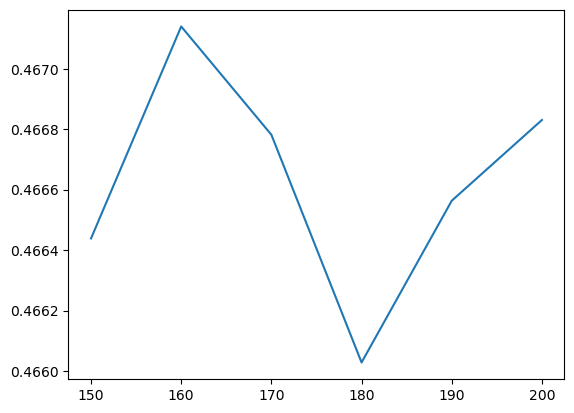

In [469]:
plt.plot(resultsRF['param_n_estimators'],resultsRF['mean_test_score'], linestyle='solid')

In [472]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split': range(90,251,10)}
# param_test2 = {'max_depth':[5,11], 'min_samples_split': range(90,251,10)}
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(n_estimators = 160, learning_rate=0.15, min_samples_leaf=10,max_features='sqrt',subsample=0.8,random_state=10), param_grid = param_test2, scoring='r2',n_jobs=-1, cv=3,verbose=3)
gsearch2.fit(X_train, y_train)

Fitting 3 folds for each of 102 candidates, totalling 306 fits
[CV 2/3] END .max_depth=5, min_samples_split=90;, score=0.485 total time=   5.6s
[CV 1/3] END .max_depth=5, min_samples_split=90;, score=0.472 total time=   5.6s
[CV 3/3] END .max_depth=5, min_samples_split=90;, score=0.461 total time=   5.6s
[CV 1/3] END max_depth=5, min_samples_split=100;, score=0.471 total time=   5.6s
[CV 2/3] END max_depth=5, min_samples_split=110;, score=0.479 total time=   5.7s
[CV 3/3] END max_depth=5, min_samples_split=100;, score=0.466 total time=   5.8s
[CV 2/3] END max_depth=5, min_samples_split=100;, score=0.479 total time=   5.8s
[CV 1/3] END max_depth=5, min_samples_split=110;, score=0.473 total time=   5.9s
[CV 3/3] END max_depth=5, min_samples_split=110;, score=0.469 total time=   5.3s
[CV 2/3] END max_depth=5, min_samples_split=120;, score=0.478 total time=   5.3s
[CV 1/3] END max_depth=5, min_samples_split=120;, score=0.472 total time=   5.4s
[CV 3/3] END max_depth=5, min_samples_split=12

GridSearchCV(cv=3,
             estimator=GradientBoostingRegressor(learning_rate=0.15,
                                                 max_features='sqrt',
                                                 min_samples_leaf=10,
                                                 n_estimators=160,
                                                 random_state=10,
                                                 subsample=0.8),
             n_jobs=-1,
             param_grid={'max_depth': range(5, 16, 2),
                         'min_samples_split': range(90, 251, 10)},
             scoring='r2', verbose=3)

In [473]:
resultsRF = pd.DataFrame(gsearch2.cv_results_)
resultsRFSorted = resultsRF.sort_values(by='rank_test_score')
resultsRFSorted

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
60,12.298430,0.292215,0.075391,0.026658,11,180,"{'max_depth': 11, 'min_samples_split': 180}",0.484663,0.502273,0.484455,0.490464,0.008351,1
66,8.087255,0.547769,0.237572,0.183349,11,240,"{'max_depth': 11, 'min_samples_split': 240}",0.482324,0.502196,0.485854,0.490124,0.008656,2
84,16.137731,0.493408,0.141501,0.048902,13,250,"{'max_depth': 13, 'min_samples_split': 250}",0.482876,0.505205,0.479628,0.489236,0.011369,3
101,16.143925,1.491852,0.094984,0.026002,15,250,"{'max_depth': 15, 'min_samples_split': 250}",0.479745,0.506925,0.480994,0.489221,0.012529,4
43,8.880480,0.162154,0.173512,0.145668,9,180,"{'max_depth': 9, 'min_samples_split': 180}",0.484053,0.499220,0.483743,0.489005,0.007224,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,6.932431,1.560995,0.041611,0.005243,5,220,"{'max_depth': 5, 'min_samples_split': 220}",0.469323,0.470434,0.458975,0.466244,0.005160,98
14,5.645955,0.101854,0.042546,0.010484,5,230,"{'max_depth': 5, 'min_samples_split': 230}",0.471019,0.467762,0.459633,0.466138,0.004788,99
15,5.746837,0.088338,0.067274,0.001603,5,240,"{'max_depth': 5, 'min_samples_split': 240}",0.470427,0.467856,0.455217,0.464500,0.006647,100
16,6.435396,0.101459,0.045652,0.013485,5,250,"{'max_depth': 5, 'min_samples_split': 250}",0.469818,0.469951,0.453449,0.464406,0.007748,101


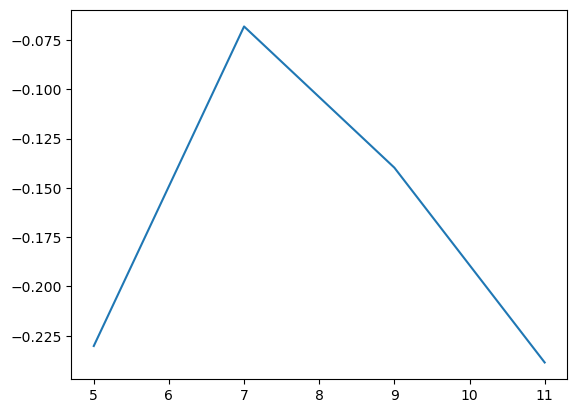

In [376]:
# resultsRF11 = resultsRF[resultsRF.param_max_depth == 11]
# resultsRF5 = resultsRF[resultsRF.param_max_depth == 5]
# resultsRF7 = resultsRF[resultsRF.param_max_depth == 7]

# plt.plot(resultsRF11['param_min_samples_split'],resultsRF11['mean_test_score'], linestyle='solid')
# plt.plot(resultsRF5['param_min_samples_split'],resultsRF5['mean_test_score'], linestyle='solid')
plt.plot(resultsRF['param_max_depth'],resultsRF['mean_test_score'], linestyle='solid')

In [400]:
param_test3 = {'min_samples_leaf':range(420,441,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingRegressor(n_estimators = 1200, min_samples_split = 350, max_depth = 7, learning_rate=0.3,max_features='sqrt',subsample=0.8,random_state=10), param_grid = param_test3, scoring='r2',n_jobs=-1, cv=5,verbose=3)
gsearch3.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 4/5] END .............min_samples_leaf=420;, score=-0.200 total time=  51.0s
[CV 2/5] END ..............min_samples_leaf=420;, score=0.366 total time=  51.6s
[CV 1/5] END ..............min_samples_leaf=420;, score=0.170 total time=  51.9s
[CV 3/5] END ..............min_samples_leaf=420;, score=0.291 total time=  51.9s
[CV 5/5] END ..............min_samples_leaf=420;, score=0.353 total time=  46.0s
[CV 2/5] END ..............min_samples_leaf=430;, score=0.364 total time=  45.8s
[CV 1/5] END ..............min_samples_leaf=430;, score=0.172 total time=  46.5s
[CV 3/5] END ..............min_samples_leaf=430;, score=0.294 total time=  46.4s
[CV 4/5] END .............min_samples_leaf=430;, score=-0.223 total time=  48.9s
[CV 5/5] END ..............min_samples_leaf=430;, score=0.339 total time=  48.8s
[CV 2/5] END ..............min_samples_leaf=440;, score=0.348 total time=  48.6s
[CV 1/5] END ..............min_samples_leaf=440;,

GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(learning_rate=0.3, max_depth=7,
                                                 max_features='sqrt',
                                                 min_samples_split=350,
                                                 n_estimators=1200,
                                                 random_state=10,
                                                 subsample=0.8),
             n_jobs=-1, param_grid={'min_samples_leaf': range(420, 441, 10)},
             scoring='r2', verbose=3)

In [401]:
resultsRF = pd.DataFrame(gsearch3.cv_results_)
resultsRFSorted = resultsRF.sort_values(by='rank_test_score')
resultsRFSorted

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,50.288717,2.220729,0.184682,0.024840,420,{'min_samples_leaf': 420},0.170309,0.365551,0.290558,-0.199541,0.352842,0.195944,0.209476,1
1,47.087126,1.294058,0.180602,0.040510,430,{'min_samples_leaf': 430},0.171592,0.363813,0.293776,-0.222526,0.338526,0.189036,0.216126,2
2,43.142884,4.567722,0.131996,0.036783,440,{'min_samples_leaf': 440},0.118251,0.348311,0.310034,-0.251976,0.340442,0.173012,0.228539,3


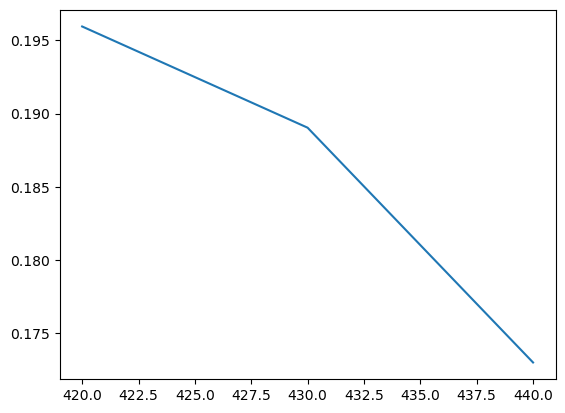

In [402]:
plt.plot(resultsRF['param_min_samples_leaf'],resultsRF['mean_test_score'], linestyle='solid')

In [406]:
param_test4 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch4 = GridSearchCV(estimator = GradientBoostingRegressor(n_estimators = 1200,min_samples_leaf = 420, min_samples_split = 350, max_depth = 5, learning_rate=0.3,max_features='sqrt',random_state=10), param_grid = param_test4, scoring='r2',n_jobs=-1, cv=5,verbose=3)
gsearch4.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 2/5] END .....................subsample=0.6;, score=0.307 total time=  37.8s
[CV 4/5] END ....................subsample=0.6;, score=-0.839 total time=  38.2s
[CV 1/5] END ....................subsample=0.6;, score=-0.134 total time=  38.4s
[CV 3/5] END .....................subsample=0.6;, score=0.304 total time=  38.4s
[CV 5/5] END .....................subsample=0.6;, score=0.319 total time=  29.3s
[CV 2/5] END .....................subsample=0.7;, score=0.340 total time=  33.3s
[CV 1/5] END ....................subsample=0.7;, score=-0.095 total time=  33.6s
[CV 3/5] END .....................subsample=0.7;, score=0.308 total time=  33.6s
[CV 4/5] END ....................subsample=0.7;, score=-0.641 total time=  33.2s
[CV 5/5] END .....................subsample=0.7;, score=0.342 total time=  33.1s
[CV 2/5] END ....................subsample=0.75;, score=0.339 total time=  35.2s
[CV 1/5] END ....................subsample=0.75;,

GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(learning_rate=0.3, max_depth=5,
                                                 max_features='sqrt',
                                                 min_samples_leaf=420,
                                                 min_samples_split=350,
                                                 n_estimators=1200,
                                                 random_state=10),
             n_jobs=-1,
             param_grid={'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]},
             scoring='r2', verbose=3)

In [407]:
resultsRF = pd.DataFrame(gsearch4.cv_results_)
resultsRFSorted = resultsRF.sort_values(by='rank_test_score')
resultsRFSorted

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,37.548347,0.250978,0.111718,0.005208,0.8,{'subsample': 0.8},0.163892,0.359694,0.273271,-0.226253,0.335914,0.181304,0.214751,1
5,35.611848,7.196900,0.090641,0.025306,0.9,{'subsample': 0.9},0.210568,0.352607,0.273902,-0.232147,0.301253,0.181237,0.211710,2
4,40.415516,0.365622,0.116082,0.004689,0.85,{'subsample': 0.85},0.164155,0.353709,0.276716,-0.249961,0.330882,0.175100,0.222393,3
2,35.404359,0.354384,0.123021,0.018579,0.75,{'subsample': 0.75},0.081144,0.338613,0.300935,-0.349405,0.345771,0.143412,0.264806,4
1,33.214237,0.187594,0.132036,0.031906,0.7,{'subsample': 0.7},-0.095300,0.340363,0.308173,-0.641489,0.341905,0.050730,0.383520,5
0,36.240412,3.526255,0.160929,0.035792,0.6,{'subsample': 0.6},-0.133973,0.306501,0.303697,-0.838983,0.319266,-0.008698,0.449348,6


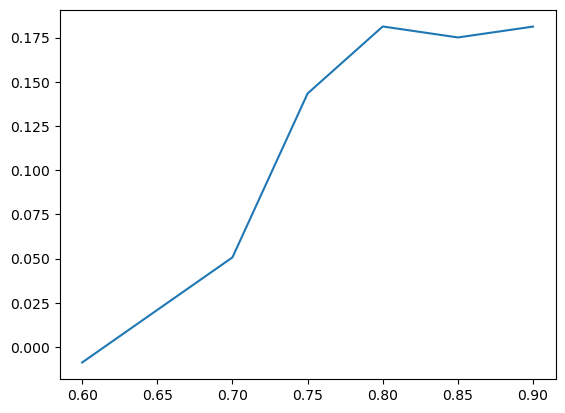

In [408]:
plt.plot(resultsRF['param_subsample'],resultsRF['mean_test_score'], linestyle='solid')

In [411]:
param_test5 = {"max_features":range(11,40,3)}
gsearch5 = GridSearchCV(estimator = GradientBoostingRegressor(n_estimators = 1200,min_samples_leaf = 420, min_samples_split = 350, max_depth = 5, learning_rate=0.3,max_features='sqrt',random_state=10), param_grid = param_test5, scoring='r2',n_jobs=-1, cv=5,verbose=3)
gsearch5.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 4/5] END ..................max_features=11;, score=-0.054 total time= 1.8min
[CV 3/5] END ...................max_features=11;, score=0.245 total time= 1.8min
[CV 1/5] END ...................max_features=11;, score=0.277 total time= 1.8min
[CV 2/5] END ...................max_features=11;, score=0.343 total time= 1.8min
[CV 5/5] END ...................max_features=11;, score=0.236 total time= 1.2min
[CV 1/5] END ...................max_features=14;, score=0.259 total time= 1.5min
[CV 3/5] END ...................max_features=14;, score=0.248 total time= 1.5min
[CV 2/5] END ...................max_features=14;, score=0.332 total time= 1.5min
[CV 4/5] END ...................max_features=14;, score=0.023 total time= 1.5min
[CV 5/5] END ...................max_features=14;, score=0.201 total time= 1.5min
[CV 1/5] END ...................max_features=17;, score=0.262 total time= 1.8min
[CV 2/5] END ...................max_features=17;

GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(learning_rate=0.3, max_depth=5,
                                                 max_features='sqrt',
                                                 min_samples_leaf=420,
                                                 min_samples_split=350,
                                                 n_estimators=1200,
                                                 random_state=10),
             n_jobs=-1, param_grid={'max_features': range(11, 40, 3)},
             scoring='r2', verbose=3)

In [415]:
resultsRF = pd.DataFrame(gsearch5.cv_results_)
resultsRFSorted = resultsRF.sort_values(by='rank_test_score')
resultsRFSorted

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,129.088566,1.382424,0.107245,0.006265,20,{'max_features': 20},0.274774,0.340322,0.215750,0.063957,0.182806,0.215522,0.092875,1
1,88.539360,0.644850,0.130958,0.046704,14,{'max_features': 14},0.258915,0.332068,0.247910,0.023060,0.200874,0.212565,0.103660,2
4,141.548499,0.327839,0.102617,0.004657,23,{'max_features': 23},0.279883,0.322583,0.216337,0.059837,0.178653,0.211458,0.090686,3
0,99.785182,14.480279,0.133570,0.022616,11,{'max_features': 11},0.276953,0.342601,0.244901,-0.054474,0.235611,0.209118,0.137027,4
2,110.581994,2.430233,0.120941,0.014107,17,{'max_features': 17},0.262319,0.337760,0.209859,0.037404,0.183991,0.206266,0.099454,5
7,238.850231,3.793324,0.113921,0.005920,32,{'max_features': 32},0.274394,0.319691,0.214831,0.053099,0.162485,0.204900,0.092680,6
8,239.190796,10.164323,0.108312,0.003661,35,{'max_features': 35},0.276429,0.303358,0.210075,0.055520,0.169651,0.203007,0.087608,7
6,208.526659,10.780472,0.104254,0.005451,29,{'max_features': 29},0.266957,0.301043,0.213895,0.057622,0.171686,0.202241,0.084775,8
5,170.526315,3.210502,0.120451,0.022811,26,{'max_features': 26},0.267488,0.320010,0.206800,0.042745,0.170359,0.201480,0.094446,9
9,212.953635,31.307981,0.087320,0.021578,38,{'max_features': 38},0.280458,0.297253,0.178154,0.057374,0.178814,0.198411,0.086241,10


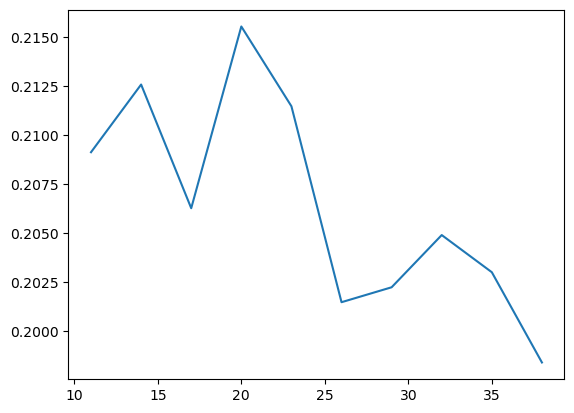

In [417]:
plt.plot(resultsRF['param_max_features'],resultsRF['mean_test_score'], linestyle='solid')

In [418]:
param_test6 = {"learning_rate":[0.005,.01,.05 ,.1,.2 ,.3]}
gsearch6 = GridSearchCV(estimator = GradientBoostingRegressor(n_estimators = 1200,min_samples_leaf = 420, min_samples_split = 350, max_depth = 5,max_features=20,random_state=10), param_grid = param_test6, scoring='r2',n_jobs=-1, cv=5,verbose=3)
gsearch6.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 2/5] END ...............learning_rate=0.005;, score=0.076 total time= 2.2min
[CV 4/5] END ...............learning_rate=0.005;, score=0.211 total time= 2.2min
[CV 3/5] END ...............learning_rate=0.005;, score=0.207 total time= 2.2min
[CV 1/5] END ...............learning_rate=0.005;, score=0.180 total time= 2.2min
[CV 5/5] END ...............learning_rate=0.005;, score=0.075 total time= 2.1min
[CV 2/5] END ................learning_rate=0.01;, score=0.101 total time= 2.1min
[CV 3/5] END ................learning_rate=0.01;, score=0.210 total time= 2.1min
[CV 1/5] END ................learning_rate=0.01;, score=0.213 total time= 2.1min
[CV 5/5] END ................learning_rate=0.01;, score=0.104 total time= 2.1min
[CV 4/5] END ................learning_rate=0.01;, score=0.196 total time= 2.2min
[CV 1/5] END ................learning_rate=0.05;, score=0.247 total time= 2.2min
[CV 2/5] END ................learning_rate=0.05;,

GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(max_depth=5, max_features=20,
                                                 min_samples_leaf=420,
                                                 min_samples_split=350,
                                                 n_estimators=1200,
                                                 random_state=10),
             n_jobs=-1,
             param_grid={'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2, 0.3]},
             scoring='r2', verbose=3)

In [419]:
resultsRF = pd.DataFrame(gsearch6.cv_results_)
resultsRFSorted = resultsRF.sort_values(by='rank_test_score')
resultsRFSorted

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,110.012835,23.978830,0.113107,0.058336,0.3,{'learning_rate': 0.3},0.274774,0.340322,0.215750,0.063957,0.182806,0.215522,0.092875,1
4,127.316568,1.482656,0.113038,0.011829,0.2,{'learning_rate': 0.2},0.272983,0.230327,0.184465,0.041074,0.178126,0.181395,0.078093,2
3,127.096719,1.125879,0.116380,0.015873,0.1,{'learning_rate': 0.1},0.269021,0.173874,0.145299,0.085484,0.171500,0.169036,0.059280,3
1,128.437595,1.747687,0.120308,0.012932,0.01,{'learning_rate': 0.01},0.213013,0.101204,0.209627,0.195748,0.104316,0.164782,0.050979,4
2,129.264414,1.039368,0.140087,0.034353,0.05,{'learning_rate': 0.05},0.247445,0.154690,0.136288,0.091504,0.158052,0.157596,0.050801,5
0,131.673558,3.510354,0.133958,0.021409,0.005,{'learning_rate': 0.005},0.179585,0.075735,0.207004,0.211065,0.074819,0.149642,0.061677,6


In [427]:
GBR =  GradientBoostingRegressor(n_estimators = 1200, min_samples_leaf = 420, min_samples_split = 350, max_depth = 5, max_features=20, learning_rate= .3, random_state=10)
GBR.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.3, max_depth=5, max_features=20,
                          min_samples_leaf=420, min_samples_split=350,
                          n_estimators=1200, random_state=10)

In [428]:
y_train_pred = GBR.predict(X_train)
print(r2_score(y_train, y_train_pred))
y_test_pred = GBR.predict(X_test)
print(r2_score(y_test, y_test_pred))

0.715701220913642
0.513123566916145


In [349]:
res = pd.DataFrame()
res["real"] = y_test
res["pred"] = y_test_pred
res.head(50)

,real,pred
0,300.0,112.599275
1,9.0,-123.329444
2,1.0,10.521427
3,256.0,322.395432
4,1001.0,3369.507256
5,495.0,3423.430312
6,1267.0,3065.106508
7,15.0,29.774289
8,60.0,-88.485385
9,20.0,-12415.521121


In [194]:
GBR.feature_importances_[sorted_idx]

array([1.33979178e-04, 6.46288793e-04, 7.36058147e-04, 8.59591502e-04,
       9.44463540e-04, 1.06290605e-03, 1.09607873e-03, 1.13421333e-03,
       1.14003103e-03, 1.30415437e-03, 1.38651997e-03, 1.66616047e-03,
       1.84152414e-03, 1.84534187e-03, 2.27725453e-03, 2.38728212e-03,
       2.40073280e-03, 2.57026461e-03, 2.75660893e-03, 3.23459904e-03,
       3.51016088e-03, 3.67697906e-03, 3.85534995e-03, 4.74032768e-03,
       4.91915452e-03, 5.54494462e-03, 5.86104635e-03, 6.14304041e-03,
       6.20299750e-03, 6.92502464e-03, 7.30613555e-03, 7.31788738e-03,
       7.79053193e-03, 8.29407607e-03, 8.41098367e-03, 1.00327990e-02,
       1.07800425e-02, 1.16090052e-02, 1.32217182e-02, 1.41881886e-02,
       1.61601811e-02, 1.86160517e-02, 2.73688312e-02, 2.82225150e-02,
       4.52965548e-02, 9.83330713e-02, 5.84248348e-01])

Text(0.5, 0, 'Random Forest Feature Importance')

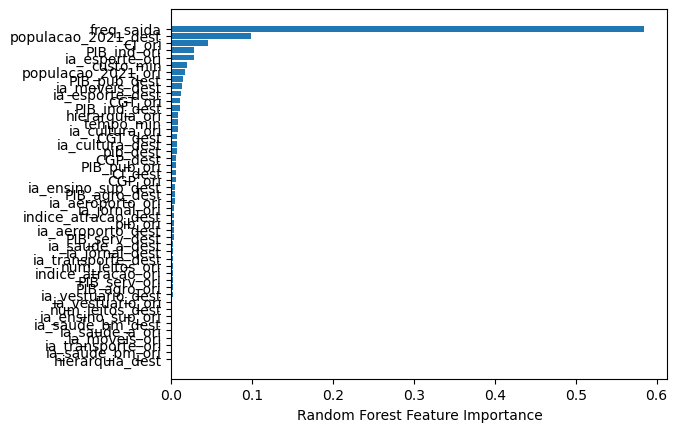

In [193]:
from matplotlib import pyplot as plt
sorted_idx = GBR.feature_importances_.argsort()
plt.barh(df_features.columns[sorted_idx], GBR.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [195]:
df_features.columns[sorted_idx]

Index(['hierarquia_dest', 'ia_saude_bm_ori', 'ia_transporte_ori',
       'ia_moveis_ori', 'ia_saude_a_ori', 'ia_saude_bm_dest',
       'ia_ensino_sup_ori', 'num_leitos_dest', 'ia_vestuario_ori',
       'ia_vestuario_dest', 'PIB_agro_ori', 'PIB_serv_ori',
       'indice_atracao_ori', 'num_leitos_ori', 'ia_transporte_dest',
       'ia_jornal_dest', 'ia_saude_a_dest', 'PIB_serv_dest',
       'ia_aeroporto_dest', 'pib_ori', 'indice_atracao_dest', 'ia_jornal_ori',
       'ia_aeroporto_ori', 'PIB_agro_dest', 'ia_ensino_sup_dest', 'CGP_ori',
       'CI_dest', 'PIB_pub_ori', 'CGP_dest', 'pib_dest', 'ia_cultura_dest',
       'CGT_dest', 'ia_cultura_ori', 'tempo_min', 'hierarquia_ori',
       'PIB_ind_dest', 'CGT_ori', 'ia_esporte_dest', 'ia_moveis_dest',
       'PIB_pub_dest', 'populacao_2021_ori', 'custo_min', 'ia_esporte_ori',
       'PIB_ind_ori', 'CI_ori', 'populacao_2021_dest', 'freq_saida'],
      dtype='object')

Balanceando Dataset

### RandomForest Regressor

In [75]:
param_test1 = {'n_estimators':range(100,300,10)}
gsearch1RF = GridSearchCV(estimator = RandomForestRegressor(min_samples_split=150,min_samples_leaf=10,max_depth=7,max_features=15,random_state=10), param_grid = param_test1, scoring='r2',n_jobs=-1, cv=5,verbose=3)
gsearch1RF.fit(X_train, y_train)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 3/5] END ..................n_estimators=100;, score=0.406 total time=  16.0s
[CV 1/5] END ..................n_estimators=100;, score=0.244 total time=  16.0s
[CV 2/5] END ..................n_estimators=100;, score=0.243 total time=  16.0s
[CV 4/5] END ..................n_estimators=100;, score=0.403 total time=  15.3s
[CV 5/5] END ..................n_estimators=100;, score=0.283 total time=  10.3s
[CV 2/5] END ..................n_estimators=110;, score=0.242 total time=  11.3s
[CV 1/5] END ..................n_estimators=110;, score=0.246 total time=  11.4s
[CV 3/5] END ..................n_estimators=110;, score=0.408 total time=  11.4s
[CV 4/5] END ..................n_estimators=110;, score=0.404 total time=  11.2s
[CV 5/5] END ..................n_estimators=110;, score=0.288 total time=  11.2s
[CV 2/5] END ..................n_estimators=120;, score=0.241 total time=  12.1s
[CV 1/5] END ..................n_estimators=120

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_depth=7, max_features=15,
                                             min_samples_leaf=10,
                                             min_samples_split=150,
                                             random_state=10),
             n_jobs=-1, param_grid={'n_estimators': range(100, 300, 10)},
             scoring='r2', verbose=3)

In [76]:
resultsRF = pd.DataFrame(gsearch1RF.cv_results_)
resultsRFSorted = resultsRF.sort_values(by='rank_test_score')
resultsRFSorted

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,17.247712,0.596029,0.097190,0.014116,150,{'n_estimators': 150},0.244112,0.240370,0.418936,0.409342,0.296086,0.321769,0.078008,1
11,21.758956,0.376764,0.118803,0.009010,210,{'n_estimators': 210},0.237747,0.243999,0.405045,0.413397,0.305117,0.321061,0.075780,2
4,17.500557,0.852035,0.113320,0.061753,140,{'n_estimators': 140},0.244390,0.237984,0.420992,0.404524,0.295529,0.320684,0.077953,3
12,20.964796,0.251901,0.121124,0.009880,220,{'n_estimators': 220},0.237418,0.244179,0.401249,0.413289,0.307081,0.320643,0.074883,4
16,25.404623,0.378176,0.150435,0.012203,260,{'n_estimators': 260},0.238727,0.244399,0.398759,0.411077,0.309472,0.320487,0.073387,5
17,25.963961,0.251926,0.147627,0.002930,270,{'n_estimators': 270},0.238403,0.244581,0.400531,0.412243,0.306613,0.320474,0.074186,6
10,19.127722,0.425009,0.110477,0.010979,200,{'n_estimators': 200},0.238647,0.243473,0.402951,0.412757,0.303609,0.320287,0.075137,7
9,18.001337,0.168118,0.104572,0.004444,190,{'n_estimators': 190},0.237740,0.242889,0.400322,0.412542,0.307110,0.320121,0.074692,8
8,20.359797,2.037203,0.097764,0.005306,180,{'n_estimators': 180},0.238922,0.241117,0.405070,0.410252,0.304868,0.320046,0.075376,9
18,26.431241,0.165461,0.147847,0.005587,280,{'n_estimators': 280},0.235930,0.242828,0.400056,0.412175,0.308022,0.319802,0.074929,10


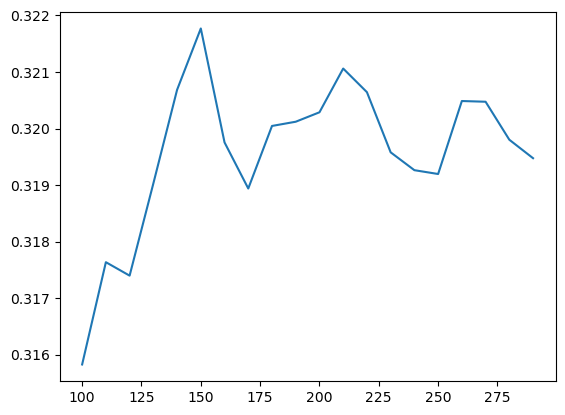

In [77]:
plt.plot(resultsRF['param_n_estimators'],resultsRF['mean_test_score'], linestyle='solid')

In [82]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(10,111,20)}
gsearch2RF = GridSearchCV(estimator = RandomForestRegressor(n_estimators= 210,min_samples_leaf=10,max_features='sqrt',random_state=10), param_grid = param_test2, scoring='r2',n_jobs=-1, cv=5,verbose=3)
gsearch2RF.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 2/5] END .max_depth=5, min_samples_split=10;, score=0.291 total time=   7.6s
[CV 4/5] END .max_depth=5, min_samples_split=10;, score=0.465 total time=   7.7s
[CV 3/5] END .max_depth=5, min_samples_split=10;, score=0.474 total time=   7.7s
[CV 1/5] END .max_depth=5, min_samples_split=10;, score=0.290 total time=   8.0s
[CV 5/5] END .max_depth=5, min_samples_split=10;, score=0.295 total time=  10.6s
[CV 1/5] END .max_depth=5, min_samples_split=30;, score=0.275 total time=  10.8s
[CV 2/5] END .max_depth=5, min_samples_split=30;, score=0.280 total time=  10.8s
[CV 3/5] END .max_depth=5, min_samples_split=30;, score=0.459 total time=  10.7s
[CV 4/5] END .max_depth=5, min_samples_split=30;, score=0.461 total time=  10.8s
[CV 5/5] END .max_depth=5, min_samples_split=30;, score=0.280 total time=  10.8s
[CV 1/5] END .max_depth=5, min_samples_split=50;, score=0.249 total time=  10.9s
[CV 2/5] END .max_depth=5, min_samples_split=50

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_features='sqrt',
                                             min_samples_leaf=10,
                                             n_estimators=210,
                                             random_state=10),
             n_jobs=-1,
             param_grid={'max_depth': range(5, 16, 2),
                         'min_samples_split': range(10, 111, 20)},
             scoring='r2', verbose=3)

In [87]:
resultsRF = pd.DataFrame(gsearch2RF.cv_results_)
resultsRFSorted = resultsRF.sort_values(by='rank_test_score')
resultsRFSorted.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
47,14.144180,0.276192,0.183110,0.011903,13,9,"{'max_depth': 13, 'min_samples_split': 9}",0.293633,0.293883,0.565091,0.493014,0.344907,0.398105,0.110904,1
41,16.096009,0.626960,0.243197,0.028302,13,3,"{'max_depth': 13, 'min_samples_split': 3}",0.293633,0.293883,0.565091,0.493014,0.344907,0.398105,0.110904,1
42,15.980084,0.768102,0.205515,0.021931,13,4,"{'max_depth': 13, 'min_samples_split': 4}",0.293633,0.293883,0.565091,0.493014,0.344907,0.398105,0.110904,1
43,15.129546,0.144328,0.191852,0.020668,13,5,"{'max_depth': 13, 'min_samples_split': 5}",0.293633,0.293883,0.565091,0.493014,0.344907,0.398105,0.110904,1
44,13.731835,0.106435,0.185193,0.017291,13,6,"{'max_depth': 13, 'min_samples_split': 6}",0.293633,0.293883,0.565091,0.493014,0.344907,0.398105,0.110904,1


In [108]:
param_test2 = {'max_depth':[13], 'min_samples_split':range(19,21,1)}
gsearch2RF = GridSearchCV(estimator = RandomForestRegressor(n_estimators= 210,min_samples_leaf=10,max_features='sqrt',random_state=10), param_grid = param_test2, scoring='r2',n_jobs=-1, cv=5,verbose=3)
gsearch2RF.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END max_depth=13, min_samples_split=19;, score=0.294 total time=  25.9s
[CV 2/5] END max_depth=13, min_samples_split=19;, score=0.294 total time=  25.9s
[CV 4/5] END max_depth=13, min_samples_split=19;, score=0.493 total time=  25.9s
[CV 3/5] END max_depth=13, min_samples_split=19;, score=0.565 total time=  26.0s
[CV 5/5] END max_depth=13, min_samples_split=19;, score=0.345 total time=  17.5s
[CV 1/5] END max_depth=13, min_samples_split=20;, score=0.294 total time=  17.6s
[CV 2/5] END max_depth=13, min_samples_split=20;, score=0.294 total time=  17.6s
[CV 3/5] END max_depth=13, min_samples_split=20;, score=0.565 total time=  17.5s
[CV 4/5] END max_depth=13, min_samples_split=20;, score=0.493 total time=  10.8s
[CV 5/5] END max_depth=13, min_samples_split=20;, score=0.345 total time=  10.9s


GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_features='sqrt',
                                             min_samples_leaf=10,
                                             n_estimators=210,
                                             random_state=10),
             n_jobs=-1,
             param_grid={'max_depth': [13], 'min_samples_split': range(19, 21)},
             scoring='r2', verbose=3)

In [109]:
resultsRF = pd.DataFrame(gsearch2RF.cv_results_)
resultsRFSorted = resultsRF.sort_values(by='rank_test_score')
resultsRFSorted.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,24.039420,3.345714,0.212339,0.011729,13,19,"{'max_depth': 13, 'min_samples_split': 19}",0.293633,0.293883,0.565091,0.493014,0.344907,0.398105,0.110904,1
1,14.706774,3.250902,0.177026,0.037116,13,20,"{'max_depth': 13, 'min_samples_split': 20}",0.293633,0.293883,0.565091,0.493014,0.344907,0.398105,0.110904,1


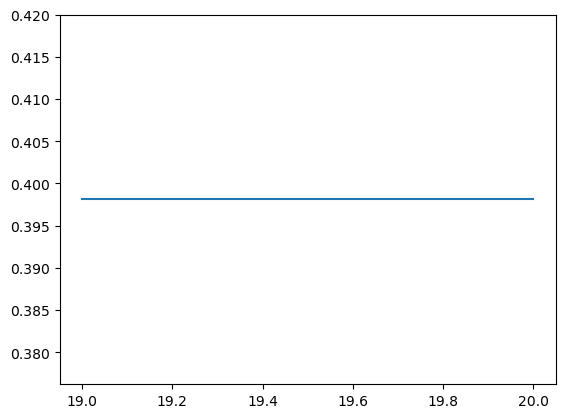

In [110]:
resultsRFPlot = resultsRF[resultsRF["param_max_depth"]==13]
plt.plot(resultsRFPlot['param_min_samples_split'],resultsRFPlot['mean_test_score'], linestyle='solid')

In [133]:
param_test3 = {'max_depth':range(20,50,2)}
gsearch3RF = GridSearchCV(estimator = RandomForestRegressor(n_estimators= 210,max_depth=32,min_samples_leaf=1, min_samples_split=2,max_features='sqrt',random_state=10), param_grid = param_test3, scoring='r2',n_jobs=-1, cv=5,verbose=3)
gsearch3RF.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END ......................max_depth=20;, score=0.872 total time=  28.5s
[CV 4/5] END ......................max_depth=20;, score=0.663 total time=  28.5s
[CV 2/5] END ......................max_depth=20;, score=0.869 total time=  28.6s
[CV 3/5] END ......................max_depth=20;, score=0.881 total time=  28.6s
[CV 5/5] END ......................max_depth=20;, score=0.837 total time=  23.9s
[CV 1/5] END ......................max_depth=22;, score=0.875 total time=  24.9s
[CV 2/5] END ......................max_depth=22;, score=0.871 total time=  25.0s
[CV 3/5] END ......................max_depth=22;, score=0.887 total time=  25.0s
[CV 4/5] END ......................max_depth=22;, score=0.670 total time=  28.5s
[CV 5/5] END ......................max_depth=22;, score=0.836 total time=  28.3s
[CV 2/5] END ......................max_depth=24;, score=0.873 total time=  29.1s
[CV 1/5] END ......................max_depth=24;

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_depth=30, max_features='sqrt',
                                             n_estimators=210,
                                             random_state=10),
             n_jobs=-1, param_grid={'max_depth': range(20, 50, 2)},
             scoring='r2', verbose=3)

In [134]:
resultsRF = pd.DataFrame(gsearch3RF.cv_results_)
resultsRFSorted = resultsRF.sort_values(by='rank_test_score')
resultsRFSorted.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,21.157048,0.070203,0.360616,0.021077,32,{'max_depth': 32},0.879133,0.870660,0.885778,0.679401,0.828175,0.828629,0.077269,1
2,28.533004,0.202482,0.721373,0.220370,24,{'max_depth': 24},0.879877,0.872903,0.879936,0.676838,0.831755,0.828262,0.077805,2
7,21.565071,0.141718,0.367033,0.019498,34,{'max_depth': 34},0.876431,0.875868,0.884315,0.683156,0.821415,0.828237,0.075936,3
4,21.066482,0.490142,0.410970,0.081898,28,{'max_depth': 28},0.876123,0.869006,0.888245,0.664942,0.842494,0.828162,0.082976,4
1,25.879603,1.620598,0.438015,0.082958,22,{'max_depth': 22},0.874527,0.870646,0.887064,0.669841,0.835673,0.827550,0.080677,5
9,21.729096,0.197837,0.427850,0.044063,38,{'max_depth': 38},0.873257,0.868631,0.886325,0.670535,0.836777,0.827105,0.079961,6
5,22.109150,0.545092,0.392500,0.046070,30,{'max_depth': 30},0.873872,0.867652,0.889380,0.670280,0.831048,0.826446,0.080395,7
3,23.506050,3.298103,0.402920,0.058783,26,{'max_depth': 26},0.880492,0.871587,0.883050,0.668317,0.825862,0.825862,0.081445,8
8,21.604104,0.125933,0.380933,0.046238,36,{'max_depth': 36},0.873798,0.867560,0.886039,0.668747,0.833123,0.825853,0.080493,9
0,26.863978,1.642217,0.740560,0.215692,20,{'max_depth': 20},0.872316,0.869090,0.880801,0.663485,0.837113,0.824561,0.081889,10


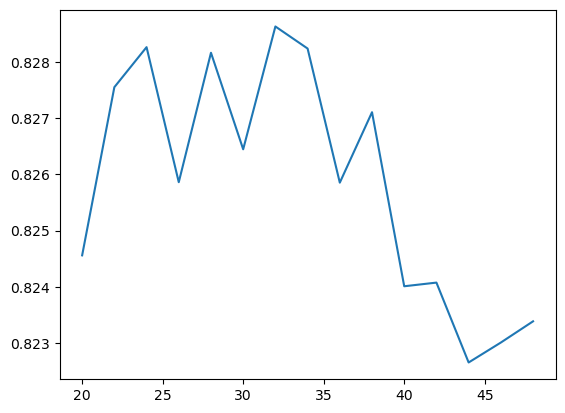

In [135]:
plt.plot(resultsRF['param_max_depth'],resultsRF['mean_test_score'], linestyle='solid')

In [362]:
best = {'n_estimators': 210, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 32, 'criterion': 'poisson', 'bootstrap': False}
rf = RandomForestRegressor(**best)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
r2_score(y_test, y_pred)

0.5977725194359124

Retirando features sem importancia

Text(0.5, 0, 'Random Forest Feature Importance')

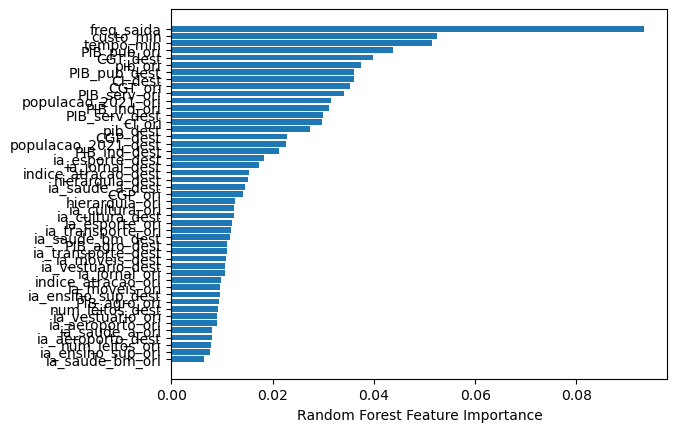

In [137]:
from matplotlib import pyplot as plt
sorted_idx = rf.feature_importances_.argsort()
plt.barh(df_features.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [202]:
res = rf.predict(X_test)
df_res = pd.DataFrame()
df_res['prediction'] = res
df_res['label'] = y_test
rf.feature_importances_

array([0.05238414, 0.05149648, 0.09333111, 0.02727832, 0.01105555,
       0.02125076, 0.02988416, 0.0361176 , 0.01510246, 0.03975548,
       0.03605677, 0.02289349, 0.01540947, 0.0106163 , 0.01067569,
       0.01147067, 0.01452442, 0.00950544, 0.01230626, 0.01826577,
       0.00800027, 0.01733598, 0.01087359, 0.00921597, 0.03745713,
       0.00943552, 0.03107475, 0.03403569, 0.04380364, 0.01253211,
       0.03525559, 0.02971719, 0.01407227, 0.00968762, 0.00904758,
       0.00950864, 0.00633314, 0.00801522, 0.00760812, 0.01233993,
       0.01188999, 0.00901907, 0.0105902 , 0.01167534, 0.00789331,
       0.02263585, 0.03156596])

In [203]:
res = pd.DataFrame()
res["real"] = y_test
res["pred"] = y_pred
res.head(50)

,real,pred
0,60.0,54.777382
1,11.0,-94.066583
2,33.0,20.102441
3,129.0,142.406818
4,459.0,532.728154
5,5.0,-134.254676
6,523.0,337.738697
7,75.0,-106.813562
8,62.0,66.523934
9,671.0,62.881334


Text(0.5, 0, 'Random Forest Feature Importance')

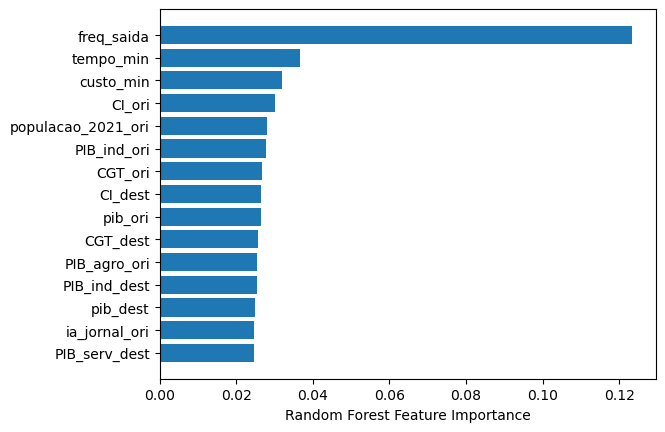

In [457]:
from matplotlib import pyplot as plt
sorted_idx = rf.feature_importances_.argsort()
plt.barh(df_features.columns[sorted_idx][-15:], rf.feature_importances_[sorted_idx][-15:])
plt.xlabel("Random Forest Feature Importance")

### XGBoost

In [224]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split


xgb1 = xgb.XGBRegressor(seed = 123)
 
# Fitting the model
xgb1.fit(X_train, y_train)
 
# Predict the model
pred = xgb1.predict(X_test)

#Caculating score
r2_score(y_test, pred)



0.8045193611092496

In [234]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='r2',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=3,
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred, gs

In [236]:
#Step 1 - Estimators e Learning Rate
model = xgb.XGBRegressor(max_depth = 5, 
                        min_child_weight = 1, 
                        gamma = 0, 
                        subsample=0.8,
                        colsample_bytree=0.8, 
                        scale_pos_weight = 1, 
                        seed=42)
param_grid = {
    'n_estimators': range(450, 551, 10),
    'learning_rate': [0.05]
}

model, pred, gs1 = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grid, cv=5)

# Root Mean Squared Error
print(np.sqrt(model.best_score_))
print(model.best_params_)
print("score_test: ",r2_score(y_test, pred))

Fitting 5 folds for each of 11 candidates, totalling 55 fits
[CV 1/5] END learning_rate=0.05, n_estimators=450;, score=0.364 total time=  25.5s
[CV 3/5] END learning_rate=0.05, n_estimators=450;, score=0.818 total time=  25.6s
[CV 4/5] END learning_rate=0.05, n_estimators=450;, score=0.499 total time=  25.9s
[CV 2/5] END learning_rate=0.05, n_estimators=450;, score=0.732 total time=  26.0s
[CV 5/5] END learning_rate=0.05, n_estimators=450;, score=0.675 total time=  26.1s
[CV 1/5] END learning_rate=0.05, n_estimators=460;, score=0.365 total time=  27.0s
[CV 2/5] END learning_rate=0.05, n_estimators=460;, score=0.732 total time=  26.9s
[CV 3/5] END learning_rate=0.05, n_estimators=460;, score=0.819 total time=  26.9s
[CV 4/5] END learning_rate=0.05, n_estimators=460;, score=0.499 total time=  27.9s
[CV 5/5] END learning_rate=0.05, n_estimators=460;, score=0.675 total time=  27.7s
[CV 1/5] END learning_rate=0.05, n_estimators=470;, score=0.365 total time=  28.4s
[CV 2/5] END learning_rate

In [237]:
resultsRF = pd.DataFrame(gs1.cv_results_)
resultsRFSorted = resultsRF.sort_values(by='rank_test_score')
resultsRFSorted.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,31.384720,0.199850,0.076586,0.005643,0.05,540,"{'learning_rate': 0.05, 'n_estimators': 540}",0.364953,0.733238,0.819430,0.499779,0.676642,0.618808,0.164499,1
10,28.677762,2.631714,0.066441,0.021703,0.05,550,"{'learning_rate': 0.05, 'n_estimators': 550}",0.364766,0.733153,0.819408,0.500085,0.676621,0.618807,0.164493,2
8,30.422321,0.255858,0.071372,0.004743,0.05,530,"{'learning_rate': 0.05, 'n_estimators': 530}",0.364458,0.733151,0.819487,0.499830,0.676745,0.618734,0.164653,3
7,30.156498,0.637699,0.073937,0.010918,0.05,520,"{'learning_rate': 0.05, 'n_estimators': 520}",0.364215,0.733083,0.819413,0.499658,0.676560,0.618586,0.164712,4
6,30.764450,1.641415,0.073552,0.012660,0.05,510,"{'learning_rate': 0.05, 'n_estimators': 510}",0.364380,0.733265,0.819215,0.499345,0.676460,0.618533,0.164676,5


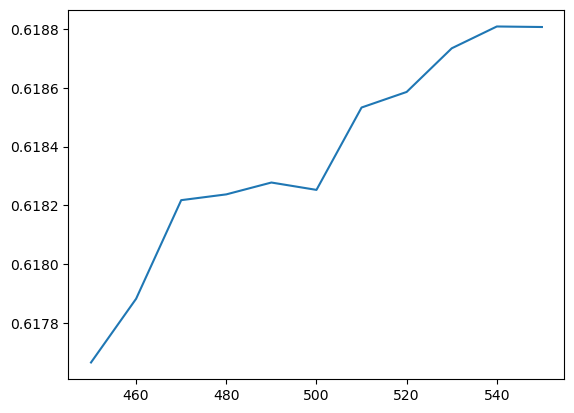

In [238]:
resultsRF11 = resultsRF[resultsRF.param_learning_rate == 0.05]
# resultsRF5 = resultsRF[resultsRF.param_max_depth == 0.05]
# resultsRF7 = resultsRF[resultsRF.param_max_depth == 7]

plt.plot(resultsRF11['param_n_estimators'],resultsRF11['mean_test_score'], linestyle='solid')
# plt.plot(resultsRF5['param_min_samples_split'],resultsRF5['mean_test_score'], linestyle='solid')
# plt.plot(resultsRF['param_max_depth'],resultsRF['mean_test_score'], linestyle='solid')

In [239]:
#Step 2 - 
model = xgb.XGBRegressor(n_estimators = 540,
                        learning_rate = 0.05,
                        gamma = 0, 
                        subsample=0.8,
                        colsample_bytree=0.8, 
                        scale_pos_weight = 1, 
                        seed=42)
param_grid = {
    'max_depth': range(3, 10, 2),
    'min_child_weight': range(1, 6, 2)
    # 'max_depth': [5,6,7],
    # 'min_child_weight': [1,2,3]
}

model, pred, gs1 = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grid, cv=5)

# Root Mean Squared Error
print(model.best_score_)
print(model.best_params_)
print("score_test: ",r2_score(y_test, pred))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 4/5] END ...max_depth=3, min_child_weight=1;, score=0.626 total time=  20.1s
[CV 2/5] END ...max_depth=3, min_child_weight=1;, score=0.740 total time=  20.2s
[CV 3/5] END ...max_depth=3, min_child_weight=1;, score=0.785 total time=  20.3s
[CV 1/5] END ...max_depth=3, min_child_weight=1;, score=0.499 total time=  20.3s
[CV 5/5] END ...max_depth=3, min_child_weight=1;, score=0.783 total time=  18.7s
[CV 2/5] END ...max_depth=3, min_child_weight=3;, score=0.650 total time=  18.6s
[CV 3/5] END ...max_depth=3, min_child_weight=3;, score=0.423 total time=  18.6s
[CV 1/5] END ...max_depth=3, min_child_weight=3;, score=0.255 total time=  18.7s
[CV 1/5] END ...max_depth=3, min_child_weight=5;, score=0.140 total time=  18.3s
[CV 5/5] END ...max_depth=3, min_child_weight=3;, score=0.763 total time=  18.3s
[CV 4/5] END ...max_depth=3, min_child_weight=3;, score=0.645 total time=  18.5s
[CV 2/5] END ...max_depth=3, min_child_weight=5;

In [240]:
resultsRF = pd.DataFrame(gs1.cv_results_)
resultsRFSorted = resultsRF.sort_values(by='rank_test_score')
resultsRFSorted.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_child_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,19.864500,0.618263,0.044025,0.004619,3,1,"{'max_depth': 3, 'min_child_weight': 1}",0.499460,0.740314,0.784821,0.625558,0.782910,0.686613,0.110050,1
3,31.554706,0.441575,0.101489,0.039145,5,1,"{'max_depth': 5, 'min_child_weight': 1}",0.364953,0.733238,0.819430,0.499779,0.676642,0.618808,0.164499,2
6,99.436171,9.418477,0.265061,0.131775,7,1,"{'max_depth': 7, 'min_child_weight': 1}",0.218615,0.757931,0.819909,0.528520,0.684065,0.601808,0.214903,3
9,83.993332,2.360717,0.227395,0.025886,9,1,"{'max_depth': 9, 'min_child_weight': 1}",0.321276,0.756611,0.721412,0.512807,0.638721,0.590165,0.158476,4
4,31.830886,0.684624,0.073451,0.003332,5,3,"{'max_depth': 5, 'min_child_weight': 3}",0.438705,0.658779,0.502874,0.593371,0.666705,0.572087,0.088884,5


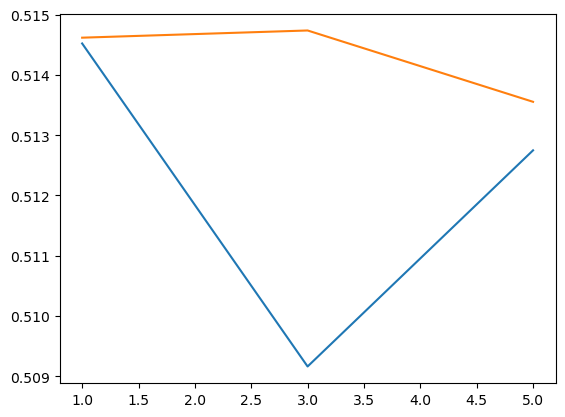

In [501]:
resultsRF5 = resultsRF[resultsRF.param_max_depth == 5]
resultsRF7 = resultsRF[resultsRF.param_max_depth == 7]
# resultsRF7 = resultsRF[resultsRF.param_max_depth == 7]

plt.plot(resultsRF5['param_min_child_weight'],resultsRF5['mean_test_score'], linestyle='solid')
plt.plot(resultsRF7['param_min_child_weight'],resultsRF7['mean_test_score'], linestyle='solid')


In [504]:
#Step 3 - Gamma
model = xgb.XGBRegressor(n_estimators = 450,
                        learning_rate = 0.1,
                        max_depth = 6,
                        min_child_weight = 2, 
                        subsample=0.8,
                        colsample_bytree=0.8, 
                        scale_pos_weight = 1,
                        seed=42)
param_grid = {
    'gamma':[i/10.0 for i in range(0,5)]
}

model, pred, gs1 = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grid, cv=3)

# Root Mean Squared Error
print(model.best_score_)
print(model.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END .........................gamma=0.1;, score=0.513 total time=  35.5s
[CV 1/3] END .........................gamma=0.0;, score=0.517 total time=  35.6s
[CV 2/3] END .........................gamma=0.0;, score=0.526 total time=  35.8s
[CV 3/3] END .........................gamma=0.0;, score=0.510 total time=  35.9s
[CV 3/3] END .........................gamma=0.1;, score=0.505 total time=  33.9s
[CV 2/3] END .........................gamma=0.1;, score=0.525 total time=  34.4s
[CV 2/3] END .........................gamma=0.2;, score=0.527 total time=  34.1s
[CV 1/3] END .........................gamma=0.2;, score=0.513 total time=  34.3s
[CV 3/3] END .........................gamma=0.2;, score=0.511 total time=  37.5s
[CV 1/3] END .........................gamma=0.3;, score=0.511 total time=  37.7s
[CV 3/3] END .........................gamma=0.3;, score=0.512 total time=  37.5s
[CV 2/3] END .........................gamma=0.3;,

In [505]:
resultsRF = pd.DataFrame(gs1.cv_results_)
resultsRFSorted = resultsRF.sort_values(by='rank_test_score')
resultsRFSorted.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,35.581617,0.118369,0.205232,0.030160,0.0,{'gamma': 0.0},0.516618,0.525856,0.510091,0.517522,0.006468,1
2,35.096348,1.582063,0.219211,0.054013,0.2,{'gamma': 0.2},0.512906,0.527432,0.511105,0.517148,0.007309,2
3,37.484880,0.160640,0.207562,0.008932,0.3,{'gamma': 0.3},0.511260,0.522564,0.512253,0.515359,0.005111,3
1,34.397012,0.667753,0.189981,0.043380,0.1,{'gamma': 0.1},0.513218,0.525098,0.504762,0.514359,0.008341,4
4,26.879008,0.166937,0.103802,0.015523,0.4,{'gamma': 0.4},0.511233,0.521552,0.503497,0.512094,0.007396,5


In [508]:
#Step 4 - 
model = xgb.XGBRegressor(n_estimators = 450,
                        learning_rate = 0.1,
                        max_depth = 6,
                        min_child_weight = 2,
                        gamma = 0, 
                        scale_pos_weight = 1,
                        seed=42)
param_grid = {
    # 'subsample':[i/10.0 for i in range(6,10)],
    # 'colsample_bytree':[i/10.0 for i in range(6,10)]
    'subsample':[i/100.0 for i in range(85,100,5)],
    'colsample_bytree':[i/100.0 for i in range(65,80,5)]
}

model, pred, gs1 = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grid, cv=3)

# Root Mean Squared Error
print(model.best_score_)
print(model.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END colsample_bytree=0.65, subsample=0.9;, score=0.514 total time=  30.4s
[CV 3/3] END colsample_bytree=0.65, subsample=0.85;, score=0.513 total time=  30.5s
[CV 2/3] END colsample_bytree=0.65, subsample=0.85;, score=0.522 total time=  30.6s
[CV 1/3] END colsample_bytree=0.65, subsample=0.85;, score=0.519 total time=  30.6s
[CV 1/3] END colsample_bytree=0.65, subsample=0.95;, score=0.519 total time=  34.3s
[CV 3/3] END colsample_bytree=0.65, subsample=0.9;, score=0.517 total time=  34.5s
[CV 2/3] END colsample_bytree=0.65, subsample=0.9;, score=0.528 total time=  34.6s
[CV 2/3] END colsample_bytree=0.65, subsample=0.95;, score=0.529 total time=  34.9s
[CV 3/3] END colsample_bytree=0.65, subsample=0.95;, score=0.518 total time=  27.5s
[CV 1/3] END colsample_bytree=0.7, subsample=0.85;, score=0.514 total time=  29.7s
[CV 3/3] END colsample_bytree=0.7, subsample=0.85;, score=0.517 total time=  29.5s
[CV 2/3] END colsampl

In [510]:
#Step 5 - 
model = xgb.XGBRegressor(n_estimators = 450,
                        learning_rate = 0.1,
                        max_depth = 6,
                        min_child_weight = 2,
                        gamma = 0,
                        subsample = .9,
                        colsample_bytree = .7,
                        scale_pos_weight = 1,
                        seed=42)
param_grid = {
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}

model, pred, gs1 = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 param_grid, cv=3)

# Root Mean Squared Error
print(model.best_score_)
print(model.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END .......................reg_alpha=0;, score=0.523 total time=  43.1s
[CV 1/3] END ...................reg_alpha=0.001;, score=0.517 total time=  43.2s
[CV 3/3] END .......................reg_alpha=0;, score=0.515 total time=  43.6s
[CV 2/3] END .......................reg_alpha=0;, score=0.530 total time=  43.7s
[CV 2/3] END ...................reg_alpha=0.001;, score=0.527 total time=  35.8s
[CV 3/3] END ...................reg_alpha=0.001;, score=0.513 total time=  36.4s
[CV 2/3] END ...................reg_alpha=0.005;, score=0.525 total time=  36.1s
[CV 1/3] END ...................reg_alpha=0.005;, score=0.518 total time=  36.4s
[CV 3/3] END ...................reg_alpha=0.005;, score=0.512 total time=  35.0s
[CV 1/3] END ....................reg_alpha=0.01;, score=0.519 total time=  34.7s
[CV 2/3] END ....................reg_alpha=0.01;, score=0.527 total time=  34.9s
[CV 3/3] END ....................reg_alpha=0.01;,

In [511]:
resultsRF = pd.DataFrame(gs1.cv_results_)
resultsRFSorted = resultsRF.sort_values(by='rank_test_score')
resultsRFSorted.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,43.207796,0.216237,0.251828,0.056125,0,{'reg_alpha': 0},0.522619,0.530068,0.514518,0.522402,0.006350,1
4,24.068493,0.153721,0.113775,0.013520,0.05,{'reg_alpha': 0.05},0.520468,0.527198,0.513065,0.520244,0.005772,2
3,34.502495,0.142253,0.232496,0.019810,0.01,{'reg_alpha': 0.01},0.518759,0.527135,0.513587,0.519827,0.005582,3
1,38.243443,3.408851,0.236706,0.099508,0.001,{'reg_alpha': 0.001},0.517473,0.527342,0.513120,0.519312,0.005950,4
2,35.608981,0.598925,0.203361,0.027320,0.005,{'reg_alpha': 0.005},0.518009,0.525115,0.511538,0.518221,0.005545,5


In [525]:
model = xgb.XGBRegressor(n_estimators = 450,
                        learning_rate = 0.1,
                        max_depth = 6,
                        min_child_weight = 2,
                        gamma = 0,
                        subsample = .9,
                        colsample_bytree = .7,
                        reg_alpha = 0,
                        seed=42)
fitted_model = model.fit(X_train, y_train)
                        

Text(0.5, 0, 'XGB Feature Importance')

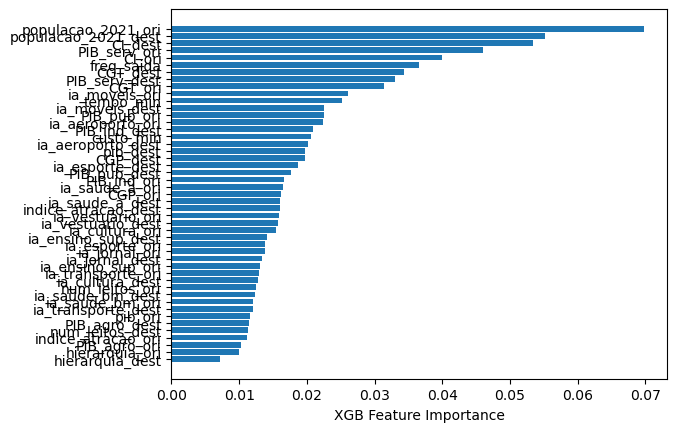

In [527]:
#XGBoost feature importance
from matplotlib import pyplot as plt
sorted_idx = model.feature_importances_.argsort()
plt.barh(df_features.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("XGB Feature Importance")

# Gerando fluxo a partir de regressor

In [224]:
# Melhor modelo
from sklearn.ensemble import GradientBoostingRegressor
GBR = GradientBoostingRegressor(n_estimators = 1200, min_samples_split = 120, max_depth = 5, learning_rate=0.3,subsample = .85,max_features=15,random_state=10)
GBR.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.3, max_depth=5, max_features=15,
                          min_samples_split=120, n_estimators=1200,
                          random_state=10, subsample=0.85)

In [269]:
#Separando features
features_columns = df_features.columns

#Dados a prever 
features_to_predict  = df_regic_merge[features_columns]

In [270]:
#Preenchendo dados faltantes
features_to_predict = features_to_predict.fillna(0)

#Label enconder
features_to_predict["hierarquia_ori"] = le.transform(features_to_predict["hierarquia_ori"])
features_to_predict["hierarquia_dest"] = le.transform(features_to_predict["hierarquia_dest"])

#Tranformando dataset to array
data = features_to_predict.to_numpy()

#Scaling
data_scaled = sc.transform(data)

In [271]:
#Realizando a predição
predicao = GBR.predict(data_scaled)

In [277]:
df_rod_final = pd.DataFrame(df_regic_merge[["cod_destino","cod_origem"]]) 
df_rod_final["passageiros_rodov_pred"] = predicao
df_rod_final[df_rod_final<0] = 0
df_rod_final['passageiros_rodov_pred'] = df_rod_final['passageiros_rodov_pred'].astype('int')

In [281]:
df_rod_final[(df_rod_final.cod_destino==2604106) & (df_rod_final.cod_origem==2611606)]


,cod_destino,cod_origem,passageiros_rodov_pred
7498,2604106,2611606,23
7499,2604106,2611606,23


In [302]:
df_lig[(df_lig.cod_origem==2604106) & (df_lig.cod_destino==2611606)]

,cod_destino,cod_origem,custo_min,tempo_min,freq_saida
56132,2611606,2604106,21.0,80,898.0


In [306]:
df_features_temp

,cod_origem,cod_destino,passageiros_rodov,passageiros_aereo,passageiros_total,prob_rodov,prob_aereo,prob_total,custo_min,tempo_min,...,ia_saude_a_ori,ia_ensino_sup_ori,ia_cultura_ori,ia_esporte_ori,ia_aeroporto_ori,ia_jornal_ori,ia_transporte_ori,num_leitos_ori,cod_cidade_ori,populacao_2021_ori
0,1100205,3131307,195.0,0.0,195.0,0.007397,0.000000,0.000495,512.00,2640,...,703520.266667,305411.296667,242445.350000,418772.066667,855048.316667,656108.950000,218109.491135,3.295974,1100205,577020.0
1,1100205,3136207,166.0,0.0,166.0,0.006297,0.000000,0.000421,670.16,3192,...,703520.266667,305411.296667,242445.350000,418772.066667,855048.316667,656108.950000,218109.491135,3.295974,1100205,577020.0
2,1100205,3205309,3.0,0.0,3.0,0.000114,0.000000,0.000008,680.91,3000,...,703520.266667,305411.296667,242445.350000,418772.066667,855048.316667,656108.950000,218109.491135,3.295974,1100205,577020.0
3,1100205,3509502,318.0,13856.0,14174.0,0.012063,0.037677,0.035963,428.04,2400,...,703520.266667,305411.296667,242445.350000,418772.066667,855048.316667,656108.950000,218109.491135,3.295974,1100205,577020.0
4,1100205,3541406,3.0,0.0,3.0,0.000114,0.000000,0.000008,447.01,2690,...,703520.266667,305411.296667,242445.350000,418772.066667,855048.316667,656108.950000,218109.491135,3.295974,1100205,577020.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22783,5221601,4219507,1.0,0.0,1.0,0.000923,0.000000,0.000923,369.22,2040,...,1173.300000,46476.399708,51864.909886,46568.613333,0.000000,77536.042964,49625.822786,2.163264,5221601,41150.0
22784,5221601,4219705,1.0,0.0,1.0,0.000923,0.000000,0.000923,374.52,2070,...,1173.300000,46476.399708,51864.909886,46568.613333,0.000000,77536.042964,49625.822786,2.163264,5221601,41150.0
22785,5221601,5201108,15.0,0.0,15.0,0.013838,0.000000,0.013838,46.01,210,...,1173.300000,46476.399708,51864.909886,46568.613333,0.000000,77536.042964,49625.822786,2.163264,5221601,41150.0
22786,5221601,5208103,1.0,0.0,1.0,0.000923,0.000000,0.000923,21.55,120,...,1173.300000,46476.399708,51864.909886,46568.613333,0.000000,77536.042964,49625.822786,2.163264,5221601,41150.0


In [287]:
df_li_trans

,cod_mun_b,cod_mun_a,custo_min,tempo_min,freq_saida
0,1302603,1304260,50.00,2160,0.0
1,1302108,1302603,230.00,8640,0.0
2,5103809,5108402,10.50,375,42.0
3,1300029,1302603,60.00,1920,0.0
4,1300029,1301308,50.00,1380,0.0
...,...,...,...,...,...
65633,2304236,2313609,9.80,148,7.0
65634,3526209,3537206,15.46,90,7.0
65635,3541406,4114104,32.76,240,14.0
65636,4114104,4114807,9.57,60,21.0


In [284]:
df_regic_lig

,id_reg,cod_origem,nome_ori,coduf_ori,uf_ori,nivel_ori,classe_ori,cod_destino,nome_dest,coduf_dest,...,quest_8,quest_9,quest_10,lig_c_tv,aero_pax,agro,agro_q1,agro_q2,agro_q3,agro_q4
0,15014021302603,1501402,Arranjo Populacional de Belém/PA,15,PA,1C,Metrópole,1302603,Manaus,13,...,0,0,0,NaN,NaN,não,0,0,0,0
1,15014022304400,1501402,Arranjo Populacional de Belém/PA,15,PA,1C,Metrópole,2304400,Arranjo Populacional de Fortaleza/CE,23,...,0,0,0,NaN,302647.0,não,0,0,0,0
2,31001043143104,3100104,Abadia dos Dourados,31,MG,5,Centro Local,3143104,Monte Carmelo,31,...,0,0,1,NaN,NaN,não,0,0,0,0
3,15014022611606,1501402,Arranjo Populacional de Belém/PA,15,PA,1C,Metrópole,2611606,Arranjo Populacional do Recife/PE,26,...,0,0,0,NaN,70738.0,não,0,0,0,0
4,15014023106200,1501402,Arranjo Populacional de Belém/PA,15,PA,1C,Metrópole,3106200,Arranjo Populacional de Belo Horizonte/MG,31,...,0,0,0,NaN,158660.0,não,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32057,21140072101202,2114007,Zé Doca,21,MA,4B,Centro de Zona B,2101202,Bacabal,21,...,0,0,0,NaN,NaN,sim,0,1,0,3
32058,21140072102002,2114007,Zé Doca,21,MA,4B,Centro de Zona B,2102002,Bom Jardim,21,...,0,0,0,NaN,NaN,não,0,0,0,0
32059,21140072106326,2114007,Zé Doca,21,MA,4B,Centro de Zona B,2106326,Maracaçumé,21,...,0,0,2,NaN,NaN,não,0,0,0,0
32060,21140072109908,2114007,Zé Doca,21,MA,4B,Centro de Zona B,2109908,Santa Inês,21,...,0,0,0,NaN,NaN,sim,1,2,0,2
